In [20]:
%pylab inline
%config InlineBackend.figure_format = 'svg'
import pylab as plb
plb.rcParams['pdf.fonttype'] = 42 #allows text in saved .pdf files to be edited in illustrator
recalc_meds = True #recalculate the groupwise median stats set to False to load from file

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [2]:
import h5py
#epoch_db = h5py.File('../imaging_post_processing/epoch_db.hdf5','a')
epoch_db = h5py.File('../02_imaging_post_processing/epoch_db_nnls_fits_bk_sub_F.hdf5','a')

In [3]:
data = dict()
data['exp_names'] = np.array(epoch_db['exp_names'])
data['fly_numbers'] = np.array(epoch_db['fly_numbers'])
data['genotypes'] = np.array(epoch_db['genotypes'])
data['signal_data'] = np.array(epoch_db['signal_data'])
data['signal_names'] = np.array(epoch_db['signal_names'])
data['trial_names'] = np.array(epoch_db['trial_names'])

In [16]:
data['flt_samples'] = np.array(epoch_db['flt_samples'])

In [21]:
# function to get the timebase using the trial name (yaw_left)
def get_xio(trial_name):
    xi = np.linspace(0,23,1150)
    #print trial_name
    if trial_name in ['ascending','descending','yaw_left','yaw_right','progressive','regressive']:
        xi -= 10.0
    if 'pth_roll' in trial_name:
        xi -= 7.0
    if 'flight' in trial_name:
        xi -= 5.0
    else:
        return xi
    return xi

In [22]:
def fly_medians(data,mask):
    """ Calculate the median and percentiles for each type 
    of trial - return in a dictionary keyed by signal and trial """
    #baseline_epoch = (xi >5) & (xi < 7)
    import group_data as gd
    reload(gd)
    ave_dict = dict()
    signal_set = set(data['signal_names'][mask])
    trial_set = set(data['trial_names'][mask])
    fly_set = set(data['fly_numbers'][mask])
    for signal in signal_set:
        ave_dict[signal] = dict()
        for trial in trial_set:
            ave_dict[signal][trial] = dict()
            for fly in fly_set:
                
                selection = (data['fly_numbers'] == fly) & \
                            (data['signal_names'] == signal) & \
                            (data['trial_names'] == trial) & \
                            (data['flt_samples'] > 800) & \
                            mask
                            
                if sum(selection) >0:
                    #print 'here'
                    #subplot(3,1,1)
                    datamtrx = data['signal_data'][selection,:]
                    #subplot(3,1,2)
                    #imshow(datamtrx, aspect = 'auto')
                    xi = get_xio(trial)
                    baseline_epoch = (xi >-3) & (xi < 0)
                    baseline = np.nanmean(data['signal_data'][selection][:,baseline_epoch],axis = 1)
                    #datamtrx = (datamtrx-baseline[:,np.newaxis])/baseline[:,np.newaxis]
                    datamtrx -= baseline[:,np.newaxis] #delta F
                    #datamtrx /= baseline[:,np.newaxis] # over F
                    #subplot(3,1,3)
                    #imshow(datamtrx,aspect = 'auto')
                    trnsfm = gd.signal_plot_info[signal]['transform']
                    ave_dict[signal][trial][fly] = trnsfm(np.nanmedian(datamtrx,axis = 0))
    return ave_dict

In [23]:
import group_data as gd
trial_types = set(data['trial_names'])
test_set = list(trial_types.difference(['flight_starts','flight_stops','stripe_fix']))
fly_set = set(gd.GMR22H05_list) | set(gd.GMR22H05_pr_list) | set(gd.GMR22H05_prc_list)
#fly_set = set(gd.GMR40D04_pr_list)

In [25]:
#mask out the data so only the trial types in test_set will be included
mask = np.zeros(shape(data['trial_names'])[0]).astype(bool)
for trial_name in test_set:
    mask = mask | (data['trial_names'] == trial_name)

#now mask out the data to only include the flys in fly_set
fly_mask = np.zeros(shape(data['trial_names'])[0]).astype(bool)
for fly in fly_set:
    fly_mask = fly_mask | (data['fly_numbers'] == fly)
mask = mask & fly_mask
#data['trial_names'] == list(test_set)[0])

In [26]:
import cPickle
if recalc_meds:
    meds = fly_medians(data,mask)
    with open('med_dict_22H05.cpkl','wb') as fi: cPickle.dump(meds,fi)
else:
    with open('med_dict_22H05.cpkl','rb') as fi: meds = cPickle.load(fi)

/home/psilentp/anaconda/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:662: RuntimeWarning: All-NaN slice encountered
  warnings.warn("All-NaN slice encountered", RuntimeWarning)


In [27]:
def get_percentiles(signal_name = 'wb_frequency',trial_set = test_set,epoch = (0,3),trial_name = None):
    data_array = np.vstack([np.array(meds[signal_name][trial_name].values()) for trial_name in trial_set])
    xi = get_xio(trial_name)
    epoch_mask = (xi > epoch[0]) & (xi < epoch[1])
    percentile_rng = arange(0,100,1)
    percentiles = [np.nanpercentile(data_array[:,epoch_mask],d) for d in percentile_rng]
    return percentiles,percentile_rng

In [28]:
def kill_spines():
    gca().spines['left'].set_visible(False)
    gca().spines['top'].set_visible(False)
    gca().spines['right'].set_visible(False)
    gca().spines['bottom'].set_visible(False)
    [x.set_visible(False) for x in plb.gca().get_xticklabels()]
    [y.set_visible(False) for y in plb.gca().get_yticklabels()]
    [x.set_visible(False) for x in plb.gca().get_xticklines()]
    [y.set_visible(False) for y in plb.gca().get_yticklines()]

In [29]:
### This plots figure 3b - ensamble responses to motion around the cardinal axes. 
fig = figure(figsize = (3.35,7))
#signal_plot_list = ['Ph1','Ph0', 'wb_frequency','b1','b2','b3','i1','i2','iii1','iii3','iii24','hg1','hg2','hg3','hg4','tpd','tpv','ttm']
signal_plot_list = ['Ph1','b1','b2','b3','i1','i2','iii1','iii3','iii24','hg1','hg2','hg3','hg4','tpd','tpv','ttm']
trial_plot_list = [['ascending','descending'],['progressive','regressive'],['yaw_left','yaw_right'],['pth_roll_180','pth_roll_0'],
                  ['pth_roll_90','pth_roll_270']]

lookup_ybound = {'Ph1':(-13,11),
                 'Ph0':(-10,14),
                 'wb_frequency':(-12,12),
                 'b1':(-0.1,0.12),
                 'b2':(-0.034,0.125),
                 'b3':(-0.09,0.27),
                 'i1':(0.02,0.7),
                 'i2':(0.02,0.4),
                 'iii1':(0.0,0.25),
                 'iii3':(-1,1),
                 'iii24':(-0.60,0.15),
                 'hg1':(-1,1.3),
                 'hg2':(-0.3,2.7),
                 'hg3':(-0.2,0.5),
                 'hg4':(-0.2,0.4),
                 'tpd':(-0.03,0.07),
                 'tpv':(-0.20,0.2),
                 'ttm':(-0.01,0.015)}

from matplotlib import gridspec

yitems = signal_plot_list
xitems = trial_plot_list

def parse_xlabel(xlabel):
    """convert vector orientations to cardinal direction labels"""
    
    red = '#82182B'
    blue = '#2166AC'

    if xlabel == 'ascending':
        return 'ascending',blue
    if xlabel == 'descending':
        return 'descending',red
    
    if xlabel == 'progressive':
        return 'progressive',blue
    if xlabel == 'regressive':
        return 'regressive',red

    if xlabel == 'yaw_left': #pattern moving from left-to-right
        return 'yaw right',blue 
    if xlabel == 'yaw_right': #pattern moving from right-to-left
        return 'yaw left',red
    
    if xlabel == 'pth_roll_180': #pattern moving down in front
        return 'pitch down',blue
    if xlabel == 'pth_roll_0': #pattern moving up in front
        return 'pitch up',red

    if xlabel == 'pth_roll_90': #pattern moving down on the right up on the left
        return 'roll right',blue
    if xlabel == 'pth_roll_270': #pattern moving up on the right down on the left
        return 'roll left',red
    
gs = gridspec.GridSpec(len(yitems),len(xitems))
for i,yitem in enumerate(yitems):
    for j,xitem in enumerate(xitems):
        fig.add_subplot(gs[i,j])
        
        signal = (yitem,xitem)[xitem in signal_plot_list]
        trials = (yitem,xitem)[xitem in trial_plot_list]
        import string
        xlabel = (gd.signal_plot_info[signal]['ax_label'],string.joinfields(trials,'\n'))[xitem in signal_plot_list]
        title = (gd.signal_plot_info[signal]['ax_label'],string.joinfields(trials,'\n'))[yitem in signal_plot_list]
        xlabel1,color1 = parse_xlabel(title.split('\n')[0])
        xlabel2,color2 = parse_xlabel(title.split('\n')[1])
        if j==0:
            gca().set_ylabel(xlabel)

        for trial,color,lbl in zip(trials,[color1,color2],[xlabel1,xlabel2]):
            kill_spines()
            xi = get_xio(trial)
            time_mask = (xi > -1) & (xi < 6)
            ub = np.nanpercentile(np.array(meds[signal][trial].values()),75,axis = 0)
            lb = np.nanpercentile(np.array(meds[signal][trial].values()),25,axis = 0)
            md = np.nanpercentile(np.array(meds[signal][trial].values()),50,axis = 0)
            fill_between(xi[time_mask],lb[time_mask],ub[time_mask],color = color,alpha = 0.6,clip_on = False,lw = 0)
            plot(xi[time_mask],md[time_mask],clip_on = False,color = color)
            if j==0:
                if signal in ['tpd','tpv','ttm']:
                    plot([0,0],[0,0.01],clip_on = False)
                elif signal in ['Ph0','Ph1','wb_freq']:
                    plot([0,0],[0,5.0],clip_on = False)
                else:
                    plot([0,0],[0,0.1],clip_on = False)

        gca().set_ybound(lookup_ybound[signal])
        gca().set_xbound(-1.2,6.2)
        gca().set_axis_bgcolor('none')
        
for i in range(len(xitems)):
    ax = fig.add_subplot(gs[:,i])
    ax.patch.set_alpha(0.0)
    axvspan(0,3,alpha = 0.1,lw=0)
    gca().set_xbound(-1.2,6.2)
    kill_spines()
    
subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.0, hspace=0.0)
 
savefig('cardinal_ax.pdf')

In [31]:
def get_pvalue_for_coef(signal,condition):
    """Calculate a matrix of p-values for the responses to motion around the cardinal axes."""
    from scipy.stats import ttest_1samp
    xi = get_xio(condition)
    selection = ((xi>0) & (xi<3))
    dta_mtrx = np.array(meds[signal][condition].values())
    mvals = np.mean(dta_mtrx[:,selection],axis = 1)
    #print shape(mvals)
    mn = np.mean(mvals)
    return ttest_1samp(mvals,0)[1],mn,mvals

In [32]:
# load up a dictionary with the p-values for each cardinal direction
# the data are sorted by direction
signal_pvalue_dict = dict()
for signal in signal_plot_list:
    signal_pvalue_dict[signal] = dict()
    for trial in trial_plot_list:
        #print trial
        pv,mn,mvals = get_pvalue_for_coef(signal,trial[0])
        signal_pvalue_dict[signal][trial[0]] = pv * mn/abs(mn)
        pv,mn,mvals = get_pvalue_for_coef(signal,trial[1])
        signal_pvalue_dict[signal][trial[1]] = pv * mn/abs(mn)
        #print get_pvalue(signal,trial[0])

/home/psilentp/anaconda/lib/python2.7/site-packages/matplotlib/backends/backend_pdf.py:2264: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  different = bool(ours != theirs)


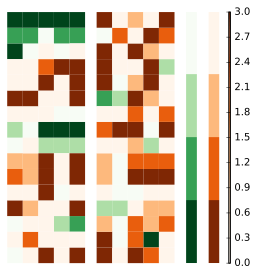

In [33]:
#Make a plot of the response p-values. Sorted by behavioral response polarity
from matplotlib.colors import LogNorm
fig = figure(figsize = (4,4.5))
gs = gridspec.GridSpec(100,100)

#Set up the axes
amp_inc_ax = fig.add_subplot(gs[:100,:35])
amp_dec_ax = fig.add_subplot(gs[:100,40:75])
amp_inc_key_ax = fig.add_subplot(gs[:100,80:85])
amp_dec_key_ax = fig.add_subplot(gs[:100,90:95])
pscale_lbl_ax = fig.add_subplot(gs[:100,95:100])

#Plot the stimuli with decreases in stroke amplitude
plot_mtrx = list()
for c_idx, c_name in enumerate(['ascending','progressive','yaw_left','pth_roll_180','pth_roll_90']):
    plot_mtrx.append(list())
    for s_idx,s_name in enumerate(['Ph1','b1','b2','b3','i1','i2','iii1','iii3','iii24','hg1','hg2','hg3','hg4','tpd','tpv','ttm']):
        plot_mtrx[c_idx].append(signal_pvalue_dict[s_name][c_name])

from matplotlib.colors import LogNorm
axes(amp_inc_ax)
plot_mtrx = np.array(plot_mtrx)

positive_mask = np.array(plot_mtrx) > 0
negative_mask = np.array(plot_mtrx) < 0 

plot_mtrx1 =  (plot_mtrx > -0.05).astype(int)*-1
plot_mtrx1 += (plot_mtrx > -0.01).astype(int)*-1
plot_mtrx1 += (plot_mtrx > -0.001).astype(int)*-1
plot_mtrx1 = rot90(ma.masked_array(plot_mtrx1,mask = positive_mask))

plot_mtrx2 = (plot_mtrx < 0.05).astype(int)
plot_mtrx2 += (plot_mtrx < 0.01).astype(int)
plot_mtrx2 += (plot_mtrx < 0.001).astype(int)
plot_mtrx2 = rot90(ma.masked_array(plot_mtrx2,mask = negative_mask))

pcolormesh(plot_mtrx1*-1,cmap = cm.Greens,vmin = 0,vmax = 3)
pcolormesh(plot_mtrx2,cmap = cm.Oranges,vmin = 0,vmax = 3)
kill_spines()

#Plot the stimuli with increases in stroke amplitude
plot_mtrx = list()
for c_idx, c_name in enumerate(['descending','regressive','yaw_right','pth_roll_0','pth_roll_270']):
    plot_mtrx.append(list())
    for s_idx,s_name in enumerate(['Ph1','b1','b2','b3','i1','i2','iii1','iii3','iii24','hg1','hg2','hg3','hg4','tpd','tpv','ttm']):
        plot_mtrx[c_idx].append(signal_pvalue_dict[s_name][c_name])
axes(amp_dec_ax)
plot_mtrx = np.array(plot_mtrx)

positive_mask = np.array(plot_mtrx) > 0
negative_mask = np.array(plot_mtrx) < 0 

plot_mtrx1 =  (plot_mtrx > -0.05).astype(int)*-1
plot_mtrx1 += (plot_mtrx > -0.01).astype(int)*-1
plot_mtrx1 += (plot_mtrx > -0.001).astype(int)*-1
plot_mtrx1 = rot90(ma.masked_array(plot_mtrx1,mask = positive_mask))

plot_mtrx2 = (plot_mtrx < 0.05).astype(int)
plot_mtrx2 += (plot_mtrx < 0.01).astype(int)
plot_mtrx2 += (plot_mtrx < 0.001).astype(int)
plot_mtrx2 = rot90(ma.masked_array(plot_mtrx2,mask = negative_mask))

pcolormesh(plot_mtrx1*-1,cmap = cm.Greens,vmin = 0,vmax = 3,lw = 10.0)
pcolormesh(plot_mtrx2,cmap = cm.Oranges,vmin = 0,vmax = 3)
kill_spines()

axes(pscale_lbl_ax)
kill_spines()
colorbar(aspect = 'auto')

axes(amp_inc_key_ax)
imshow(np.array([linspace(1.0,0.0,4)]).T,aspect = 'auto',interpolation='nearest',cmap = cm.Greens_r)
kill_spines()

axes(amp_dec_key_ax)
imshow(np.array([linspace(1.0,0.0,4)][::-1]).T,aspect = 'auto',interpolation='nearest',cmap = cm.Oranges_r)
kill_spines()
savefig('cardinal_pval.pdf')